<a href="https://colab.research.google.com/github/is0280fp/google_colab/blob/use_image_as_input/training_spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# ラベルの読み込み
import pickle
# with open("/content/drive/MyDrive/pickle/label_five_class.pickle", mode="rb") as f:
#    label = pickle.load(f)
# f.close()
with open("/content/drive/MyDrive/pickle/label_HC_vs_GD_class.pickle", mode="rb") as f:
   label = pickle.load(f)
f.close()

In [60]:
# データセット内訳チェック
import numpy as np

print(np.array(np.where(label == 0)).shape)
print(np.array(np.where(label == 1)).shape)
print(np.array(np.where(label == 2)).shape)
print(np.array(np.where(label == 3)).shape)
print(np.array(np.where(label == 4)).shape)

# NaNチェック
print(np.isnan(label).sum())

(1, 7755)
(1, 67977)
(1, 0)
(1, 0)
(1, 0)
0


In [4]:
label.shape

(75732,)

In [5]:
import tensorflow as tf
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, InputLayer, Dense, Dropout, Activation, Flatten, concatenate, Conv1D, MaxPooling1D, Input, Reshape, Bidirectional, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
import time
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from PIL import Image
import numpy as np

# NAME = "HC-vs-C-LSTM_2class"
# NAME = "HC-vs-A-LSTM_2class"
# NAME = "HC-vs-K-LSTM_2class"
# NAME = "HC-vs-H-LSTM_2class"
# NAME = "HC-vs-GDs-LSTM_2class"
# NAME = "H-vs-K-vs-A-vs-C-LSTM_4class"
#NAME = "HC-vs-H-vs-K-vs-A-vs-C-LSTM_5class"
# NAME = "H-vs-K-vs-A-vs-C-CNN_4class"
# NAME = "HC-vs-Patients-CNN_5class"
NAME = "HC-vs-GDs-CNN_2class"
# NAME = "HC-vs-H-CNN_2class"
# NAME = "HC-vs-K-CNN_2class"
# NAME = "HC-vs-A-CNN_2class"
# NAME = "HC-vs-C-CNN_2class"

#-----------------------------------初期設定-------------------------------------------
# tensorboardのログ
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

# 学習打ち切り目安
early_stopping = EarlyStopping(
                        monitor='val_loss',
                        min_delta=0.0,
                        patience=10,
                )

# checkpointの設定
checkpoint = ModelCheckpoint(
                    filepath="saved_model/{}".format(NAME),
                    monitor='val_loss',
                    save_best_only=True,
                    period=1,
                )

# weightの初期化
# initializer = tf.initializers.he_normal()

#-----------------------------------学習モデル作成-------------------------------------------


#-----------------------------------Optimizer-------------------------------------------
# Optimizer: 多クラス分類+Adam
# model.compile(loss='sparse_categorical_crossentropy', 
#               optimizer= optimizers.Adam(lr=0.002, beta_1= 0.9, beta_2= 0.999),
#               metrics=['accuracy'],
#               )

# Optimizer: 多クラス分類+SGD
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer= optimizers.SGD(lr=5e-2, decay=1e-2),
#               metrics=['accuracy'],
#               )

# Optimizer: 2クラス分類
# model.compile(loss='binary_crossentropy',
#               optimizer= optimizers.SGD(lr=5e-3),
#               metrics=['accuracy'],
#               )

#-----------------------------------summer出力-------------------------------------------
# model.summary()

#-----------------------------------学習-------------------------------------------
# model.fit(X, train_label,
#           batch_size=5,
#           epochs=1000,
#           validation_split=0.2,
#           callbacks=[tensorboard])

# training parameters = kernel_size * (1Dだったらここは1, 2Dだったらここはkernel_size) * output_channels + num_bias
# 216 = 8 * 1 * 24 + 24

In [7]:
# 入力データの加工

def conv_binary(number):
  V_left_filename = '/content/spectrogram_data/V_left/{}.png'.format(number)
  V_right_filename = '/content/spectrogram_data/V_right/{}.png'.format(number)
  V_left_img = Image.open(V_left_filename)
  V_right_img = Image.open(V_right_filename)
  V_left_img = V_left_img.resize(size=(224, 112), resample=Image.BICUBIC)
  V_right_img = V_right_img.resize(size=(224, 112), resample=Image.BICUBIC)
  V_left_rgb = np.array(V_left_img.convert('RGB')).astype('float32')
  V_right_rgb = np.array(V_right_img.convert('RGB')).astype('float32')
  V_left_rgb /= 255.0
  V_right_rgb /= 255.0
  # # numpy配列の取得
  img_array = np.concatenate([V_left_rgb, V_right_rgb], axis=0)
  return img_array

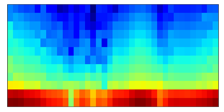

In [24]:
number=1
V_left_filename = '/content/spectrogram_data/V_left/{}.png'.format(number)
V_right_filename = '/content/spectrogram_data/V_right/{}.png'.format(number)
V_left_img = Image.open(V_left_filename)
V_right_img = Image.open(V_right_filename)
V_left_img = V_left_img.resize(size=(224, 112), resample=Image.BICUBIC)
V_right_img = V_right_img.resize(size=(224, 112), resample=Image.BICUBIC)
# V_left_rgb = np.array(V_left_img.convert('RGB')).astype('float32')
# V_right_rgb = np.array(V_right_img.convert('RGB')).astype('float32')
# V_left_rgb /= 255.0
# V_right_rgb /= 255.0
# # # numpy配列の取得
# img_array = np.concatenate([V_left_rgb, V_right_rgb], axis=0)
V_left_img
V_right_img

In [26]:
np.array(V_left_img).shape
np.concatenate([np.array(V_left_img), np.array(V_right_img)], axis=0).shape

(224, 224, 4)

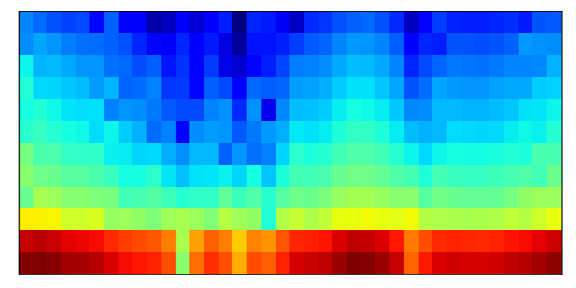

In [17]:
number=1
V_left_filename = '/content/spectrogram_data/V_left/{}.png'.format(number)
V_right_filename = '/content/spectrogram_data/V_right/{}.png'.format(number)
V_left_img = Image.open(V_left_filename)
V_right_img = Image.open(V_right_filename)
V_left_img = V_left_img.resize(size=(576, 288), resample=Image.BICUBIC)
V_right_img = V_right_img.resize(size=(576, 288), resample=Image.BICUBIC)
# V_left_rgb = np.array(V_left_img.convert('RGB')).astype('float32')
# V_right_rgb = np.array(V_right_img.convert('RGB')).astype('float32')
# V_left_rgb /= 255.0
# V_right_rgb /= 255.0
# # # numpy配列の取得
# img_array = np.concatenate([V_left_rgb, V_right_rgb], axis=0)
V_left_img
V_right_img

In [8]:
def get_batch(batch_size, X, Y):
    """
    batchを取得する関数
    """
    SIZE = len(X)
    # n_batchs
    n_batchs = SIZE//batch_size
    # for でyield
    i = 0
    while ((i+batch_size) < SIZE):
        # print("doing", i, "/", n_batchs)
        # Y_batch = Y[(i * n_batchs):(i * n_batchs + batch_size)]
        Y_batch = Y[i:(i + batch_size)]
        
        #あるbatchのfilenameの配列を持っておく
        # X_batch_name = X[(i * n_batchs):(i * n_batchs + batch_size)]
        X_batch_name = X[i:(i + batch_size)]

        # filenameにしたがってバッチのtensorを構築
        X_batch = np.array([conv_binary(file) for file in X_batch_name])
        
        # これで(batch_size, 28, 28, 1)のtrainのテンソルが作られる
        i += 1
        yield X_batch, Y_batch

In [17]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input, Dropout
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import CSVLogger
from sklearn.model_selection import StratifiedKFold

n_categories=2
N_EPOCHS = 1000
BATCH_SIZE = 50

# acquire the .png name
TRAINS = np.array(range(len(label)))
y = label
# # split test and train
# X_train, X_test, Y_train, Y_test = train_test_split(
#     TRAINS, y, test_size=0.1, random_state=42)

# split test and the others
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(
    TRAINS, y, test_size=0.1, random_state=42)

# split k-folds (その中の一つのfoldがvalidationのためのtestデータとなる)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for X_index, Y_index in skf.split(X_train_and_val, Y_train_and_val):
    # print("train_index:", train_index, "val_index:", val_index)
    # print("train data", X_train_and_val[X_index])
    # print("train label", Y_train_and_val[X_index])
    # print("test data", X_train_and_val[Y_index])
    # print("test label", Y_train_and_val[Y_index])

    train_data = X_train_and_val[X_index]
    train_label = Y_train_and_val[X_index]
    test_data = X_train_and_val[Y_index]
    test_label = Y_train_and_val[Y_index]

    steps_per_epoch=len(X_train_and_val[X_index])//BATCH_SIZE 
    validation_steps=len(X_train_and_val[Y_index])//BATCH_SIZE 

training_generator = get_batch(BATCH_SIZE, train_data, train_label)
validation_generator = get_batch(BATCH_SIZE, test_data, test_label)

vgg_model = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

#add new layers instead of FC networks
x=vgg_model.output
x=Flatten()(x) # Flatten dimensions to for use in FC layers
x=Dense(256, activation='relu')(x)
x=Dropout(0.5)(x) # Dropout layer to reduce overfitting
# x = Dense(256, activation='relu')(x)
x = Dense(n_categories, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg_model.input, outputs=x)

#fix weights before VGG16 14layers
for layer in vgg_model.layers[:15]:
    layer.trainable=False

transfer_model.compile(optimizer=optimizers.Adam(lr=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

transfer_model.summary()

hist=transfer_model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=N_EPOCHS
    )

#save weights
transfer_model.save(file_name+'.h5')

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
1226/1226 [==============================] - 757s 610ms/step - loss: 0.2409 - accuracy: 0.9354 - val_loss: 0.4853 - val_accuracy: 0.8718
Epoch 2/1000
 234/1226 [====>.........................] - ETA: 8:53 - loss: 0.0452 - accuracy: 0.9912

KeyboardInterrupt: ignored

In [20]:
print(steps_per_epoch)
print(len(X_train_and_val[X_index]))
print(BATCH_SIZE)

7667
61343
8


In [ ]:
print(X_train_and_val[X_index].shape)
print(X_index.shape)
print(X_train_and_val[X_index][0])
print(X_index[0])
TRAINS

In [ ]:
# データの読み込み 
# yesを選ぶように!
!unzip /content/drive/MyDrive/zip_spectrogram_data/AP_left.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/AP_right.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/AP_right_69826.zip

In [ ]:
# データの読み込み
# yesを選ぶように!
!unzip /content/drive/MyDrive/zip_spectrogram_data/ML_left.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/ML_left_58106.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/ML_right.zip

In [ ]:
# データの読み込み
# yesを選ぶように!
!unzip /content/drive/MyDrive/zip_spectrogram_data/V_left.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/V_left_48327.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/V_right.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/V_right_34533.zip

In [ ]:
img = Image.open("/content/spectrogram_data/ML_left/58106.png")
img

In [77]:
with open("/content/drive/MyDrive/pickle/metadata_for_GRF.pickle", mode="rb") as f:
   metadata_for_GRF = pickle.load(f)
f.close()

# 2クラス分類(HC vs A VS K)
# (HC=0, H=1, K=2, A=3, C=4)
data_list = []
label_list = []
TRIAL_num = len(metadata_for_GRF)
class_label = 2
HC = 0
H = 1
K = 2
A = 3
C = 4

for i in range(TRIAL_num):
  if metadata_for_GRF[i, class_label] == HC:
    data_list.append(i)
    label_list.append(0)
  elif metadata_for_GRF[i, class_label] == H: 
    data_list.append(i)
    label_list.append(1)
  elif metadata_for_GRF[i, class_label] == C: 
    data_list.append(i)
    label_list.append(2)

data_list = np.array(data_list)
label_list = np.array(label_list)

In [53]:
# originalデータのlabelとつくったlabelがあっているか確認、データの順番もlabelの順番とあっているか確認
# (HC=0, H=1, K=2, A=3, C=4)
# SUBJECT_ID, SESSION_ID, CLASS_LABEL, AFFECTED_SIDE, TRAIN. TEST
print("file_name", data_list[43110])  
print("Index of class_label = C", np.where(0 == label_list[::])) 
print("class_label", metadata_for_GRF[75731, 2]) 

file_name 75731
Index of class_label = C (array([11870, 11871, 11872, ..., 43108, 43109, 43110]),)
class_label 0.0


In [76]:
import numpy as np

print(np.array(np.where(np.array(label_list) == 0)).shape)
print(np.array(np.where(np.array(label_list) == 1)).shape)
print(np.array(np.where(np.array(label_list) == 2)).shape)
print(np.array(np.where(np.array(label_list) == 3)).shape)
print(np.array(np.where(np.array(label_list) == 4)).shape)

# NaNチェック
print(np.isnan(label_list).sum())

(1, 7755)
(1, 19873)
(1, 12748)
(1, 0)
(1, 0)
0


In [78]:
with open("/content/drive/MyDrive/pickle/HC_H_C_file_name.pickle", mode="wb") as f:
   pickle.dump(data_list, f)

In [79]:
with open("/content/drive/MyDrive/pickle/HC_H_C_label.pickle", mode="wb") as f:
   pickle.dump(label_list, f)

In [7]:
import csv
with open('/content/drive/MyDrive/GaitRect/GRF_F_AP_PRO_left.csv') as f:
    reader = csv.reader(f)
    AP_left = [row for row in reader]
f.close()

AP_left_items = np.array(AP_left, dtype=str)[0,::]
AP_left = np.array(AP_left)[1:,::]
AP_left = np.array(AP_left, dtype=float)

In [8]:
with open('/content/drive/MyDrive/pickle/metadata.pickle', mode="rb") as f:
    metadata = pickle.load(f)
f.close()

metadata = np.array(metadata)

In [10]:
with open('/content/drive/MyDrive/pickle/metadata_for_GRF.pickle', mode="rb") as f:
    metadata_for_GRF = pickle.load(f)
f.close()

In [19]:
# originalデータのlabelとつくったlabelがあっているか確認、データの順番もlabelの順番とあっているか確認
print("Session_id", AP_left[18186, 1]) 
print("Session_id", AP_left[18187, 1]) 
print("Session_id", AP_left[18188, 1]) 
print("Session_id", AP_left[18189, 1]) 
print("Session_id", AP_left[18190, 1]) 
print("Session_id", AP_left[18191, 1]) 
print("Session_id", AP_left[18192, 1])
print("Session_id", AP_left[18193, 1]) 
print("Session_id", AP_left[18194, 1])  
print("Session_id", AP_left[18195, 1])  
print("Index of Session_id=15666",np.where(15666.0 == metadata_for_GRF[::,1]))
print("class_label", metadata_for_GRF[18186, 2]) 
print("class_label", metadata_for_GRF[18187, 2]) 
print("class_label", metadata_for_GRF[18188, 2]) 
print("class_label", metadata_for_GRF[18189, 2]) 
print("class_label", metadata_for_GRF[18190, 2])
print("class_label", metadata_for_GRF[18191, 2])  
print("class_label", metadata_for_GRF[18192, 2]) 
print("class_label", metadata_for_GRF[18193, 2]) 
print("class_label", metadata_for_GRF[18194, 2]) 
print("class_label", metadata_for_GRF[18195, 2]) 
# print("Label of Session_id=413", np.where(999910375 == metadata[-1,1].astype("float16")))
print(metadata[0])
print("original_session_id",metadata[-1,1])
print("original_class_label",metadata[-1,2])

Session_id 15666.0
Session_id 15666.0
Session_id 15666.0
Session_id 15666.0
Session_id 15666.0
Session_id 15666.0
Session_id 15666.0
Session_id 15666.0
Session_id 15666.0
Session_id 15666.0
Index of Session_id=15666 (array([18186, 18187, 18188, 18189, 18190, 18191, 18192, 18193, 18194,
       18195]),)
class_label 3.0
class_label 3.0
class_label 3.0
class_label 3.0
class_label 3.0
class_label 3.0
class_label 3.0
class_label 3.0
class_label 3.0
class_label 3.0
['SUBJECT_ID' 'SESSION_ID' 'CLASS_LABEL' 'CLASS_LABEL_DETAILED' 'SEX'
 'AGE' 'HEIGHT' 'BODY_WEIGHT' 'BODY_MASS' 'SHOE_SIZE' 'AFFECTED_SIDE'
 'SHOD_CONDITION' 'ORTHOPEDIC_INSOLE' 'SPEED' 'READMISSION' 'SESSION_TYPE'
 'SESSION_DATE' 'TRAIN' 'TRAIN_BALANCED' 'TEST']
original_session_id 15666
original_class_label A
